### Module

In [1]:
from dotenv import load_dotenv
import os
from typing import List, Optional, Annotated
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import chain as as_runnable
from langchain_core.messages import AnyMessage
from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()

True

### LLM 세팅

In [2]:
fast_llm = ChatOpenAI(model="gpt-4o-mini")
long_context_llm = ChatOpenAI(model="gpt-4o")

# Outline 생성을 위한 작업
* 사용자의 topic에 대해서, wikipedia 형식의 초안을 작성

In [3]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Wikipedia writer. Write an outline for a Wikipedia page about a user-provided topic. Be comprehensive and specific.",
        ),
        ("user", "{topic}"),
    ]
)

class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()
    
class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()

class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Wikipedia page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()

generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)

In [4]:
example_topic = "Impact of million-plus token context window language models on RAG"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

# Impact of Million-Plus Token Context Window Language Models on RAG

## Introduction

An overview of language models and their relevance in natural language processing (NLP). Introduction to the concept of a context window, particularly in relation to million-plus token models and their significance in Retrieval-Augmented Generation (RAG).

## Understanding Language Models

A detailed explanation of language models, including their architecture, training processes, and the evolution from traditional models to modern transformer-based models.

## Context Windows in Language Models

Definition and importance of context windows in language models. Discussion on how larger context windows enhance model capabilities in understanding and generating human-like text.

## Retrieval-Augmented Generation (RAG)

An explanation of the RAG framework, including its components: retrieval and generation. Discussion on how RAG improves the performance of language models by incorporating external knowle

# Expand Topics
* 검색엔진을 활용해 관련성있는 최신 정보를 통합 하여 더 나은 결과로 개선

In [5]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects. I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.
       Please list the as many subjects and urls as you can.
       Topic of interest: {topic}
    """
    )

class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )

expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [6]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['Impact of million-plus token context window language models on RAG', 'Language models', 'Contextual language models', 'Retrieval-augmented generation (RAG)', 'Natural language processing', 'Machine learning', 'Artificial intelligence', 'Transformers in AI', 'Text generation', 'Large language models', 'Tokenization in NLP', 'Applications of language models', 'AI and language understanding', 'Ethics in AI'])

# Generate Perspectives

In [12]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.", pattern=r'^[a-zA-Z0-9_-]+$'
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations. The name should be this pattern : ^[a-zA-Z0-9_-]+$",
        # Add a pydantic validation/restriction to be at most M editors
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You need to select a diverse (and distinct) group of Wikipedia editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic.\
    You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on.

    Wiki page outlines of related topics for inspiration:
    {examples}""",
        ),
        ("user", "Topic of interest: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | ChatOpenAI(
    model="gpt-4o"
).with_structured_output(Perspectives)

In [13]:
wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)


def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [14]:
perspectives = await survey_subjects.ainvoke(example_topic)

In [15]:
perspectives.dict()

{'editors': [{'affiliation': 'AI Research Institute',
   'name': 'Dr_Samantha_Lee',
   'role': 'Lead Researcher',
   'description': 'Dr. Lee will focus on the technical advancements of language models with million-plus token context windows and how these improvements enhance retrieval-augmented generation (RAG) capabilities. She will explore the scalability of these models and their potential to process and generate more accurate and contextually rich responses.'},
  {'affiliation': 'OpenAI',
   'name': 'John_Martinez',
   'role': 'AI Ethicist',
   'description': 'John will explore the ethical implications of using large context window language models in RAG, including issues related to data privacy, bias, and misinformation. He aims to ensure that these models are developed and deployed responsibly.'},
  {'affiliation': 'Tech Industry Consultant',
   'name': 'Emily_Tan',
   'role': 'Industry Analyst',
   'description': 'Emily will analyze the commercial applications and market impact 

# Expert Dialog

### interview state 정의

In [16]:
def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right

def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references

def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor

class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

##### 1. Dialog Roles

In [17]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder

gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced Wikipedia writer and want to edit a specific page. \
Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic. \
Now, you are chatting with an expert to get information. Ask good questions to get more useful information.

When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
Please only ask one question at a time and don't ask what you have asked before.\
Your questions should be related to the topic you want to write.
Be comprehensive and curious, gaining as much unique insight from the expert as possible.\

Stay true to your specific perspective:

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [18]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[-1],
        "messages": messages,
    }
)

question["messages"][0].content

"Yes, I'm focusing on how language models with million-plus token context windows can enhance Retrieval-Augmented Generation (RAG) systems. Can you explain how these extended context windows change the way RAG systems retrieve and generate information?"

In [19]:
question["messages"]

[AIMessage(content="Yes, I'm focusing on how language models with million-plus token context windows can enhance Retrieval-Augmented Generation (RAG) systems. Can you explain how these extended context windows change the way RAG systems retrieve and generate information?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 225, 'total_tokens': 270, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, name='Lisa_Chen', id='run-7192aff5-f39c-4ffc-b52e-de40ed4f21df-0', usage_metadata={'input_tokens': 225, 'output_tokens': 45, 'total_tokens': 270, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]

##### 2. Answer questions

In [20]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )


gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    model="gpt-4o"
).with_structured_output(Queries, include_raw=True)

In [21]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['impact of large token context windows on RAG systems',
 'extended context windows in language models and RAG systems',
 'large context windows in language models and retrieval-augmented generation',
 'how do million-plus token contexts enhance RAG systems',
 'effects of large context windows on information retrieval and generation in RAG systems']

In [22]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer.",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert who can use information effectively. You are chatting with a Wikipedia writer who wants\
 to write a Wikipedia page on the topic you know. You have gathered the related information and will now use the information to form a response.

Make your response as informative as possible and make sure every sentence is supported by the gathered information.
Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLS after your response.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [23]:
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

'''
# Tavily is typically a better search engine, but your free queries are limited
search_engine = TavilySearchResults(max_results=4)

@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = tavily_search.invoke(query)
    return [{"content": r["content"], "url": r["url"]} for r in results]
'''

# DDG
search_engine = DuckDuckGoSearchAPIWrapper()


@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r["href"]} for r in results]

In [24]:
import json

from langchain_core.runnables import RunnableConfig


async def gen_answer(
    state: InterviewState,
    config: Optional[RunnableConfig] = None,
    name: str = "Subject_Matter_Expert",
    max_str_len: int = 15000,
):
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].tool_calls[0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state["messages"].extend([ai_message, tool_message])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [25]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

'Language models with million-plus token context windows significantly enhance Retrieval-Augmented Generation (RAG) systems by allowing them to ingest and process vast amounts of information simultaneously. This increased context capacity enables RAG systems to retrieve and utilize more extensive datasets, improving the relevance and accuracy of generated responses. For instance, traditional RAG systems often rely on retrieving a limited number of relevant documents or chunks of text; however, with extended context windows, the model can directly analyze these documents in their entirety, leading to a more nuanced understanding of the information at hand[^1^].\n\nMoreover, the integration of long context windows allows RAG systems to reduce the frequency of retrieval operations, as the model can hold more information at once, thereby decreasing latency and improving efficiency during the generation phase. This is particularly beneficial in scenarios where the data is complex or interre

##### 3. Construct the Interview Graph

In [26]:
max_num_turns = 5
from langgraph.pregel import RetryPolicy


def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question, retry=RetryPolicy(max_attempts=5))
builder.add_node("answer_question", gen_answer, retry=RetryPolicy(max_attempts=5))
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.add_edge(START, "ask_question")
interview_graph = builder.compile(checkpointer=False).with_config(
    run_name="Conduct Interviews"
)

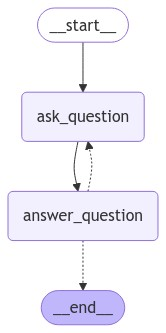

In [27]:
from IPython.display import Image, display

try:
    display(Image(interview_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
final_step = None

initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}?",
            name="Subject_Matter_Expert",
        )
    ],
}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]["messages"]))
final_step = step

ask_question
--  [AIMessage(content="Yes, that's correct! I'm particularly interested in how the advancements in language models with million-plus token context windows can improve retrieval-augmented generation (RAG) capabilities. Could you explain how these longer context windows contribute to the effectiveness of RAG systems in real-world applications?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 248, 'total_tokens': 303, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, name='Dr_Samantha_Lee', id='run-0cafffc3-a003-4da3-8590-5bc8eb913d36-0', usage_metadata={'input_tokens': 248, 'output_tokens': 55, 'total_tokens': 303, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning':